# US Senate Example
https://voteview.com/

This example uses two datasets from the 114th (2015 - 2017) US Congress (Senate only):
* [s114_votes.csv](https://voteview.com/static/data/out/votes/S114_votes.csv): Every vote cast by the senators (100 senators x 502 votes = 50,200 records)
* [s114_members.csv](https://voteview.com/static/data/out/members/S114_members.csv): Information about the senators including name and party affiliation (100 senators = 100 records)

### A little help from our friends...

* [matplotlib](https://matplotlib.org/) 
* [NumPy](https://numpy.org/) 
* [pandas](https://pandas.pydata.org/) 
* [scikit-learn](https://scikit-learn.org/)

Installation:
```
conda install matplotlib
conda install numpy
conda install pandas
conda install scikit-learn
```

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

### Data wrangling

Load the voting data into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `votes` using [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).

In [2]:
votes = pd.read_csv('data/s114_votes.csv')
votes

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,114,Senate,1,14009,6,100.0
1,114,Senate,1,14226,6,100.0
2,114,Senate,1,14307,1,90.5
3,114,Senate,1,14435,1,99.8
4,114,Senate,1,14440,1,91.1
...,...,...,...,...,...,...
50195,114,Senate,502,49308,6,34.1
50196,114,Senate,502,49700,6,8.9
50197,114,Senate,502,49703,1,69.3
50198,114,Senate,502,49706,1,91.8


Simplify the `votes` DataFrame so that it only contains the required information: `senator_id`, `vote_id`, and `vote_cast`.

In [3]:
votes = pd.DataFrame({
    'senator_id': votes.icpsr.astype('str'),
    'vote_id': votes.rollnumber.astype('str'),
    'vote_cast': votes.cast_code.astype('category')
})
votes

,senator_id,vote_id,vote_cast
0,14009,1,6
1,14226,1,6
2,14307,1,1
3,14435,1,1
4,14440,1,1
...,...,...,...
50195,49308,502,6
50196,49700,502,6
50197,49703,502,1
50198,49706,502,1


[Join](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) the `votes` DataFrame to itself on `vote_id` and `vote_cast`. This will produce a `senator_pairs` DataFrame that contains senator pairs (`senator_id_a`, `senator_id_b`) with one row for each time that senator pair cast the same vote.

In [4]:
votes.set_index(['vote_id', 'vote_cast'], inplace=True)
senator_pairs = votes.join(votes, lsuffix='_a', rsuffix='_b')
senator_pairs.reset_index(drop=True, inplace=True)
senator_pairs['n'] = 1
senator_pairs

,senator_id_a,senator_id_b,n
0,14307,14307,1
1,14307,14435,1
2,14307,14440,1
3,14307,14651,1
4,14307,14858,1
...,...,...,...
3031913,94659,49308,1
3031914,94659,49700,1
3031915,94659,49703,1
3031916,94659,49706,1


[Group](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) the `senator_pairs` DataFrame by senator pair (`senator_id_a`, `senator_id_b`) and count the number of rows for each pair. This will produce a new `senator_pairs` DataFrame that shows the total number of times each senator pair cast the same vote.

In [5]:
senator_pairs = senator_pairs.groupby(['senator_id_a', 'senator_id_b']).n.count().to_frame().reset_index()
senator_pairs

,senator_id_a,senator_id_b,n
0,14009,14009,502
1,14009,14226,434
2,14009,14307,206
3,14009,14435,181
4,14009,14440,213
...,...,...,...
9995,94659,49308,156
9996,94659,49700,439
9997,94659,49703,335
9998,94659,49706,402


[Pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) the `senator_pairs` DataFrame. This will create a co-occurrence matrix `matrix` that is 100 rows (one for each senator) by 100 columns (one for each senator) and shows how often every senator cast the same vote as every other senator.

In [6]:
matrix = senator_pairs.pivot(index='senator_id_a', columns='senator_id_b')
matrix

n                                                        ...  \
senator_id_b 14009 14226 14307 14435 14440 14503 14651 14806 14852 14858  ...   
senator_id_a                                                              ...   
14009          502   434   206   181   213   463   231   434   459   209  ...   
14226          434   502   181   168   189   446   206   435   445   189  ...   
14307          206   181   502   461   446   206   427   171   176   460  ...   
14435          181   168   461   502   431   185   406   150   150   460  ...   
14440          213   189   446   431   502   211   423   175   183   452  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
49308          226   207   454   447   430   228   432   196   194   461  ...   
49700          408   417   154   141   158   399   159   403   430   161  ...   
49703          396   378   296   272   296   393   293   363   375   299  ...   
49706          418   432   176   160   181   420   191   423   434   184  ...   
94659          394   417   143   138   161   390   160   395   420   162  ...   

                                                                          
senator_id_b 41502 41503 41504 41505 49300 49308 49700 49703 49706 94659  
senator_id_a                                                              
14009          441   380   450   470   250   226   408   396   418   394  
14226          470   405   450   444   224   207   417   378   432   417  
14307          175   133   187   196   438   454   154   296   176   143  
14435          159   134   172   175   419   447   141   272   160   138  
14440          178   143   194   206   448   430   158   296   181   161  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
49308          201   155   215   216   460   502   159   299   195   156  
49700          428   417   408   411   175   159   502   339   414   439  
49703          368   305   380   390   312   299   339   502   353   335  
49706          442   393   427   431   210   195   414   353   502   402  
94659          422   418   405   402   168   156   439   335   402   502  

[100 rows x 100 columns]

 ### Clustering

The co-occurrence matrix can also be viewed as 100 different 100-dimensional coordinates that locate each senator in voting space. Coordinates can be clustered, even 100-dimensional ones.

Use [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering to group the senators into 2 clusters.

In [7]:
km = KMeans(n_clusters=2, random_state=123).fit(matrix)
clusters = pd.DataFrame({ 'cluster': km.labels_ }, matrix.index.rename('senator_id'))
clusters

,cluster
senator_id,
14009,1
14226,1
14307,0
14435,0
14440,0
...,...
49308,0
49700,1
49703,1


### Cluster evaluation

Load additional data about the senators (name, party) into the DataFrame `senators`.

In [8]:
senators = pd.read_csv('data/s114_members.csv')
senators = pd.DataFrame({
    'senator_id': senators.icpsr.astype('str'),
    'party': senators.party_code.astype('category'),
    'name': senators.bioname
})
senators.party.cat.rename_categories(['D', 'R', 'I'], inplace=True)
senators.set_index('senator_id', inplace=True)
senators.sort_index(inplace=True)
senators

,party,name
senator_id,,
14009,R,"COCHRAN, William Thad"
14226,R,"GRASSLEY, Charles Ernest"
14307,D,"LEAHY, Patrick Joseph"
14435,D,"MARKEY, Edward John"
14440,D,"MIKULSKI, Barbara Ann"
...,...,...
49308,D,"MURRAY, Patty"
49700,R,"SESSIONS, Jefferson Beauregard III (Jeff)"
49703,R,"COLLINS, Susan Margaret"


Look at the senators in cluster `0`.

In [9]:
senators[clusters.cluster == 0]

,party,name
senator_id,,
14307,D,"LEAHY, Patrick Joseph"
14435,D,"MARKEY, Edward John"
14440,D,"MIKULSKI, Barbara Ann"
14651,D,"NELSON, Clarence William (Bill)"
14858,D,"SCHUMER, Charles Ellis (Chuck)"
14871,D,"WYDEN, Ronald Lee"
15011,D,"BOXER, Barbara"
15015,D,"CARPER, Thomas Richard"
15021,D,"DURBIN, Richard Joseph"


Look at the senators in cluster `1`.

In [10]:
senators[clusters.cluster == 1]

,party,name
senator_id,,
14009,R,"COCHRAN, William Thad"
14226,R,"GRASSLEY, Charles Ernest"
14503,R,"HATCH, Orrin Grant"
14806,R,"COATS, Daniel Ray"
14852,R,"ROBERTS, Charles Patrick (Pat)"
14921,R,"McCONNELL, Addison Mitchell (Mitch)"
15039,R,"McCAIN, John Sidney, III"
15424,R,"INHOFE, James Mountain"
20100,R,"FLAKE, Jeff"


Create a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) that plots each senators' party `senators.party` against their cluster assignment `clusters.cluster` using [matplotlib](https://matplotlib.org/3.1.1/gallery/index.html).

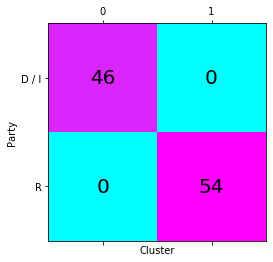

In [11]:
cm = confusion_matrix(senators.party == 'R', clusters.cluster == 1)
fig, ax = plt.subplots()
ax.matshow(cm, cmap='cool')
ax.set(xlabel='Cluster', ylabel='Party', yticklabels=[None, 'D / I', 'R'])
for (i, j), n in np.ndenumerate(cm):
    ax.text(j, i, n, ha='center', va='center', fontsize=20)
plt.show()

##### Attribution
Voteview
* https://voteview.com/